# Making a diagnostic
This notebook aims to help you make a new diagnostic function.

In [1]:
from pathlib import Path
from datatree import DataTree
import xarray as xr
import pandas as pd
import valenspy as vp
import numpy as np

## Demo data
The demo data set is already in CF convention so no input conversion and preprocessing is needed.

In [2]:
demo_data = vp.demo_data_CF
demo_ds = xr.open_dataset(demo_data)
vp.cf_checks.is_cf_compliant(demo_ds)

True

If more intrecate/complex data is needed to test the new diagnostic we recommend using CMIP6 data from Google cloud.

In [3]:
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df

#Querry the data you need
temperature_data = df.query("table_id== 'Amon' & source_id == 'EC-Earth3-Veg' & variable_id == 'tas' & experiment_id == 'historical' & member_id == 'r1i1p1f1' & activity_id == 'CMIP'")

#Load the data using the zstore link (note here the first (and only) row is used as the query returned a unique dataset)
ds_ec_temp = xr.open_zarr(temperature_data.zstore.values[0])
print(vp.cf_checks.is_cf_compliant(ds_ec_temp))
ds_ec_temp

True


<xarray.Dataset> Size: 1GB
Dimensions:    (lat: 256, bnds: 2, lon: 512, time: 1980)
Coordinates:
    height     float64 8B ...
  * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
    lat_bnds   (lat, bnds) float64 4kB dask.array<chunksize=(256, 2), meta=np.ndarray>
  * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    lon_bnds   (lon, bnds) float64 8kB dask.array<chunksize=(512, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
    time_bnds  (time, bnds) datetime64[ns] 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 1GB dask.array<chunksize=(126, 256, 512), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        CMIP
    branch_method:                      standard
    branch_time_in_child:               0.0
    branch_time_in_parent:              29219.0
    cmor_version:                       3.4.0
    ...                                 ...
    table_info:                         Creation Date:(09 May 2019) MD5:cde93...
    title:                              EC-Earth3-Veg output prepared for CMIP6
    tracking_id:                        hdl:21.14100/009fd018-f3fe-4316-ac94-...
    variable_id:                        tas
    variant_label:                      r1i1p1f1
    version_id:                         v20211207

## Let's make a new diagnostic

To make a new diagnostic, you need to define a 2 functions:
1. `diagnostic` function that takes a dataset and returns a diagnostic value.
2. `diagnostic_plot` function that takes output from the `diagnostic` function and returns a plot.

There are several types of diagnostics, depending on the type different input/outputs are expected. 

### Model2Ref

This compares 1 single model to a reference. Therefore, a Model2Ref diagnostic expects the following inputs:
- `data`: **xarray dataset** of the model data
- `ref`: **xarray dataset** of the reference data

the diagnostic function returns the results (this can be any type of data) and the plot function returns a plot.

#### Let's take a look at the example below

In [4]:

def warming_levels(ds, ref, levels=[1.5, 2.0], rol_years=21, freq_monthly=True):
    """
    Calculate the crossing times for different warming levels - the time when the area average warming crosses a certain level compared to the reference period

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing the model data
    ref : xarray.Dataset
        Dataset containing the reference period
    levels : list
        List of warming levels to get crossing times for
    rol_years : int
        Number of years to use for the rolling mean
    freq : str, optional
        Frequency of the data (following pandas conventions), default is None and will be inferred from the data
    
    Returns
    -------
    crossingtimes : dict
        Dictionary containing the crossing times for each warming level
    temp_warming : xarray.DataArray
        DataArray containing the area average warming compared to the reference period
    """
    if not freq_monthly:
        ds = ds.resample(time="ME").mean()
    warming_ds = temp_warming(ds, ref, rol_amount=rol_years*12)
    warming_ds = warming_ds.load() #Ensure that the warming_ds is only computed once (not every time it is accessed)
    crossingtimes = {}
    for level in levels:
        try:
            crossingtimes[level] = warming_ds.where(warming_ds>level, drop=True).idxmin('time').astype('datetime64[ns]').values
        except ValueError:
            crossingtimes[level] = False
    return warming_ds, crossingtimes

def temp_warming(ds, ref, rol_amount):
    """
    Calculate the area average warming compared to the reference period

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing the model data
    ref : xarray.Dataset
        Dataset containing the reference period
    rol_years : int
        Number of years to use for the rolling mean
    
    Returns
    -------
    ds_temp_warming : xarray.DataArray
        DataArray containing the area average warming compared to the reference period
    """
    ref_temp = ref.tas.mean()
    rol = ds.mean(dim=['lat','lon']).tas.rolling(time=rol_amount).mean()
    ds_temp_warming = rol - ref_temp

    return ds_temp_warming

In [5]:
def crossing_time_plot(tw_ds, ct, ax, **kwargs):    
    for level in ct:
        if ct[level]:
            ax.axhline(level, color='black', linestyle='--', alpha=0.5, label=f'{level}°C warming level: {np.datetime_as_string(ct[level], unit="M")}')
            ax.axvline(ct[level], color='black', linestyle='--', alpha=0.2)
    tw_ds.plot(ax=ax, **kwargs)
    max_temp = tw_ds.max()
    ax.legend()
    ax.set_ylabel('Temperature anomaly (°C) compared to 1850-1900')
    ax.set_xlabel('Time')
    return ax

### Write your own Model2Ref diagnostic and plotting function

In [6]:
#Note that ds and rf are expected to be xarray datasets, add aditional arguments to your function if needed
def your_diagnostic_function(ds: xr.Dataset, ref: xr.Dataset) -> DataTree: #Replace DataTree with your expected output type!
    pass #Replace this with your code

def your_diagnostic_plotting_function():
    pass #

Test the functions perform as expected with the demo data

In [7]:
#Test your function

## Finally make the diagnostic

In [8]:
example_diag = vp.Model2Ref(warming_levels, crossing_time_plot, 'Warming levels', 'Calculate the crossing times for different warming levels')

Apply it

In [9]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler
ref_temp = ds_ec_temp.sel(time=slice('1850', '1900'))

with ProgressBar():
    with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
        result_M2R = example_diag.apply(ds_ec_temp, ref_temp, levels=[0.5, 1, 1.5, 2, 3], rol_years=20)

[########################################] | 100% Completed | 12.88 s


This gives an overview of cpu, memory and cache usage during the computations - the output is provided in the html file.
It can be usefull to optimize your diagnostic functions.
```python
from dask.diagnostics import visualize
visualize([prof, rprof, cprof], filename="profile_dask.html")
```	

Plot it

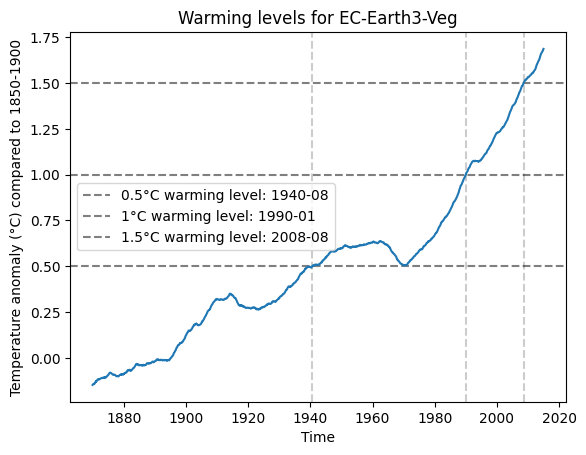

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
example_diag.visualize(result_M2R)
plt.title('Warming levels for EC-Earth3-Veg')
plt.show()

## Congratulations! You have made a new diagnostic function!
You can now add it to the diagnostics_functions.py file so everyone can use it.

TODO: short guideline on how to add a new diagnostic function to the diagnostics_functions.py file.

### An Ens2Ref diagnostic example

Let's expand the example to include multiple models. This is an Ens2Ref diagnostic. Here we will simply create a Ens2Ref diagnostic from a Model2Ref diagnostic by applying the Model2Ref diagnostic to each model in the ensemble and plotting all the results (either on the same plot or facetted). Note this is already implemented and can be easily extended, however you can also make your own Ens2Ref diagnostic from scratch.

#### Get the ensemble data
First we get the ensemble data. Set ten to true to select multiple models else only two models are selected.

In [15]:
ten=False
if ten:#Still issues with some of these times being in cf_time instead of datetime64
    CMIP6_tas_monthly_dict = {}
    temperature_data = df.query("table_id== 'Amon' & variable_id == 'tas' & experiment_id == 'historical' & member_id == 'r1i1p1f1' & activity_id == 'CMIP' & grid_label=='gr'")
    for index, row in temperature_data.iterrows():
        ds = xr.open_zarr(row.zstore)
        CMIP6_tas_monthly_dict[f"CMIP6/{row.source_id}"] = ds
    dt = DataTree.from_dict(CMIP6_tas_monthly_dict)
else:
    import pandas as pd
    df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
    temperature_data = df.query("table_id== 'Amon' &  source_id == 'MIROC6'  & variable_id == 'tas' & experiment_id == 'historical' & member_id == 'r1i1p1f1' & activity_id == 'CMIP'")
    ds_MIROC6_temp = xr.open_zarr(temperature_data.zstore.values[0])
    dt = DataTree.from_dict({'Ensemble/EC-Earth3-Veg': ds_ec_temp, 'Ensemble/MIROC6': ds_MIROC6_temp})
dt

DataTree('None', parent=None)
└── DataTree('Ensemble')
    ├── DataTree('EC-Earth3-Veg')
    │       Dimensions:    (lat: 256, bnds: 2, lon: 512, time: 1980)
    │       Coordinates:
    │           height     float64 8B ...
    │         * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
    │           lat_bnds   (lat, bnds) float64 4kB dask.array<chunksize=(256, 2), meta=np.ndarray>
    │         * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    │           lon_bnds   (lon, bnds) float64 8kB dask.array<chunksize=(512, 2), meta=np.ndarray>
    │         * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
    │           time_bnds  (time, bnds) datetime64[ns] 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
    │       Dimensions without coordinates: bnds
    │       Data variables:
    │           tas        (time, lat, lon) float32 1GB dask.array<chunksize=(126, 256, 512), meta=np.ndarray>
    │       Attributes: (12/49)
    │           Conventions:                        CF-1.7 CMIP-6.2
    │           activity_id:                        CMIP
    │           branch_method:                      standard
    │           branch_time_in_child:               0.0
    │           branch_time_in_parent:              29219.0
    │           cmor_version:                       3.4.0
    │           ...                                 ...
    │           table_info:                         Creation Date:(09 May 2019) MD5:cde93...
    │           title:                              EC-Earth3-Veg output prepared for CMIP6
    │           tracking_id:                        hdl:21.14100/009fd018-f3fe-4316-ac94-...
    │           variable_id:                        tas
    │           variant_label:                      r1i1p1f1
    │           version_id:                         v20211207
    └── DataTree('MIROC6')
            Dimensions:    (lat: 128, bnds: 2, lon: 256, time: 1980)
            Coordinates:
                height     float64 8B ...
              * lat        (lat) float64 1kB -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
                lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(128, 2), meta=np.ndarray>
              * lon        (lon) float64 2kB 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
                lon_bnds   (lon, bnds) float64 4kB dask.array<chunksize=(256, 2), meta=np.ndarray>
              * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
                time_bnds  (time, bnds) datetime64[ns] 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
            Dimensions without coordinates: bnds
            Data variables:
                tas        (time, lat, lon) float32 260MB dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
            Attributes: (12/47)
                Conventions:            CF-1.7 CMIP-6.2
                activity_id:            CMIP
                branch_method:          standard
                branch_time_in_child:   0.0
                branch_time_in_parent:  0.0
                cmor_version:           3.3.2
                ...                     ...
                tracking_id:            hdl:21.14100/861a07b8-a8b2-414b-91c8-b557bac73bd2...
                variable_id:            tas
                variant_label:          r1i1p1f1
                status:                 2019-10-25;created;by nhn2@columbia.edu
                netcdf_tracking_ids:    hdl:21.14100/861a07b8-a8b2-414b-91c8-b557bac73bd2...
                version_id:             v20181212

In [16]:
#Make a Ensemble2Ref diagnostic from the Model2Ref diagnostic
example_diag_ensemble = vp.Ensemble2Ref.from_model2ref(example_diag)

In [17]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler
ref_temp = ds_ec_temp.sel(time=slice('1850', '1900')) #Either use a fixed reference for all models (In this case the EC-Earth3-Veg model)
ref = dt.sel(time=slice('1850', '1900')) #Or use a different reference for each model - the same data tree structure is expected

with ProgressBar():
    result = example_diag_ensemble.apply(dt, ref, levels=[0.5, 1, 1.5, 2, 3], rol_years=21)

[########################################] | 100% Completed | 11.41 s
[########################################] | 100% Completed | 3.99 ss


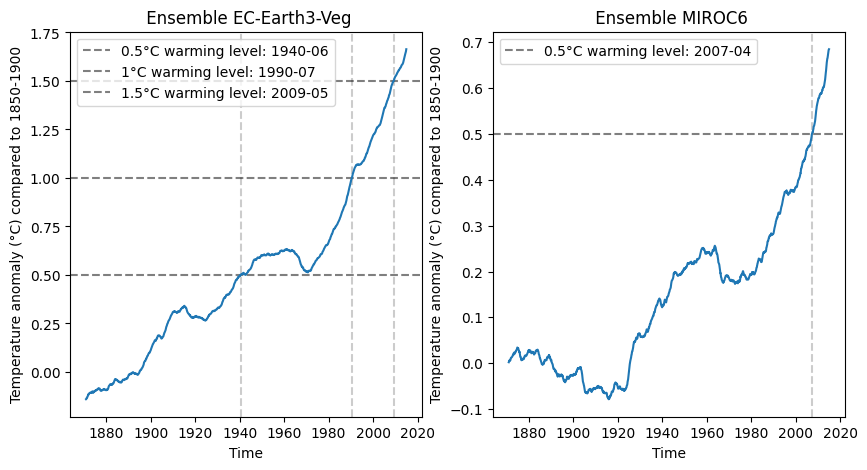

In [18]:
example_diag_ensemble.visualize(result, facetted=True)
plt.show()

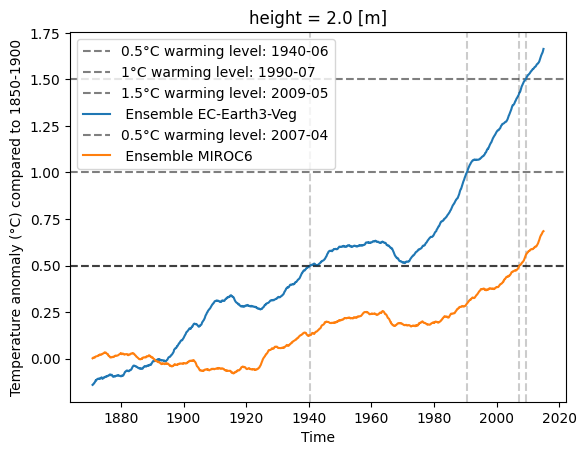

In [19]:
example_diag_ensemble.visualize(result, facetted=False)